# Market Making with Reinforcement Learning

In [34]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Libraries import environment as env
from Libraries import agents as ag
from Libraries import approximators as val_approx
from data.data_gen import DataGenerator

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Setup the training environment

In [35]:
lob_data = DataGenerator._generator('data/lob.csv', levels=1)
lob_data = lob_data.head(1200).values

# Set the boundaries for the state space
boundaries = np.array([lob_data.min(axis=0), lob_data.max(axis=0)]).T * np.array([0.8, 1.2])

In [36]:
# Create the environment
env = env.MarketMakerEnv(
    lob_data=lob_data,
    horizon=1000,
    phi_transorm=env.PhiTransform.PnL_asymm_dampened(-0.5),
)
initial_state = env.reset()
display(initial_state)

array([ 2.23990000e+02,  1.00000000e+02,  2.23750000e+02,  7.40000000e+01,
        2.23870000e+02,  2.40000000e-01, -5.00000000e-03, -1.49425287e-01,
       -2.60000000e+01, -2.23338917e-05,  2.40100065e-05,  4.16666667e+01])

In [37]:
# Define the agent
agent = ag.SarsaAgent(
    env=env,
    value_function=val_approx.TileCodingValueFunction(
        num_tiles=100,
        num_tilings=20,
        state_bounds=boundaries,
        action_space_n=env.ACTIONS_0_8.shape[0],
    ),
    alpha=1e-3,
    gamma=0.99,
    epsilon=0.1,
    epsilon_decay=0.995,
    epsilon_min=1e-2,
)

# Train the agent
train_rewards = agent.train(n_episodes=300)

Training:   0%|          | 0/300 [00:00<?, ?episode/s]

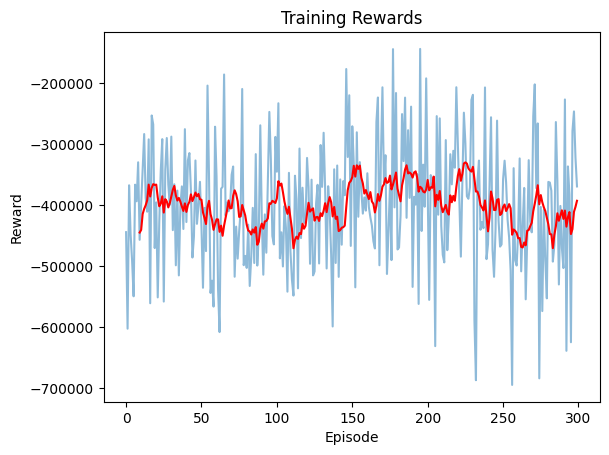

In [38]:
train_rewards_SMAs = pd.Series(train_rewards).rolling(window=10).mean()

plt.plot(train_rewards, alpha=0.5)
plt.plot(train_rewards_SMAs, color='red')
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [39]:
# Test the agent
test_rewards = agent.test(n_episodes=3)

Testing:   0%|          | 0/3 [00:00<?, ?episode/s]

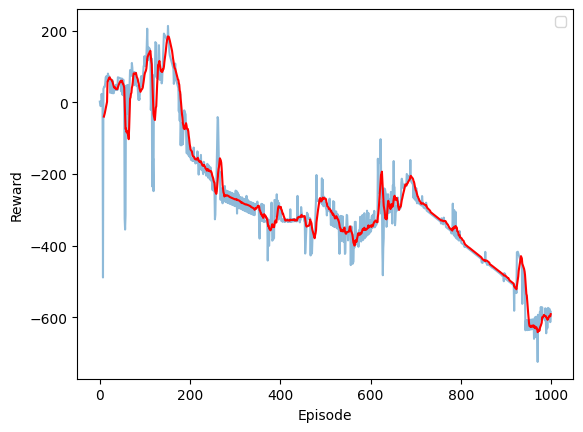

In [40]:
# Smooth the rewards
sma_window = 10
rewards_sma = pd.Series(test_rewards).rolling(window=sma_window).mean()

# Plot the rewards
plt.plot(test_rewards, alpha=0.5)
plt.plot(rewards_sma, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()